## Kaggleのデータセットを用いてモデルを構築する

### 目的：タイタニック号の乗客のデータから、生存率を予測する
#### Titanic: Machine Learning from Disaster」URL:https://www.kaggle.com/anderas/car-consume

#### ※利用するデータ
- 「train.csv」（学習データ数：891行12列）
- 「test.csv」（テストデータ数：418行11列 ※Survived列がない）

| 列 | 項目 | 項目名 | 欠損有無 | 利用有無 |
| :--- | :--- | :--- | :---: | :---: |
|  1 | PassengerId |識別ID | - | - |
|  2 | Survived | 生存有無 | - | ○ |
|  3 | Pclass | チケットクラス | - | ○ |
|  4 | Name | 名前 | - | - |
|  5 | Sex | 性別 | - | ○ |
|  6 | Age | 年齢 | 欠損あり | ○ |
|  7 | SibSp | タイタニック号に乗る兄弟/配偶者の数 | - | ○ |
|  8 | Parch | タイタニック号に乗る親/子供の数 | - | ○ |
|  9 | Ticket | チケット | - | - |
| 10 | Fare | 旅客運賃 | 欠損あり | ○ |
| 11 | Cabin | 客室番号 | 欠損あり | - |
| 12 | Embarked| 乗船港 C =シェルブール、Q =クイーンズタウン、S =サザンプトン | 欠損あり | ○ |

In [262]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import warnings
from collections import Counter

# ============================================================================
# 関数：各データの件数を確認するグラフ
# 引数：データフレーム、データ名,グラフの横幅、縦幅、降順ソート指定
# ============================================================================
def show_state_count_plot(p_df, col_name, w, h, sort_flg=False):
    plt.figure(figsize=(w,h))
    if(sort_flg):
        print("\n▼ " + str(col_name) + "別の生存数と死亡数（降順）")
        ax = sns.countplot(p_df[col_name],hue=p_df['Survived'],order = p_df[col_name].value_counts().index)
    else:
        print("\n▼ " + str(col_name) + "別の生存数と死亡数 ")
        ax = sns.countplot(p_df[col_name],hue=p_df['Survived'])
        
    ax.set_title("Count by " + str(col_name))
    ax.set_xlabel(col_name)
    ax.set_ylabel("Count")
    plt.legend()
    plt.show()

# ============================================================================
# 関数：各データの成功率を確認するグラフ
# 引数：データフレーム、データ名,グラフの横幅、縦幅、降順ソート有無
# ============================================================================
def show_s_rate_barplot(p_df, col_name, w, h, sort_flg=False):
    s_rate = pd.DataFrame(p_df['Survived'].groupby(p_df[col_name]).mean())
    s_rate.reset_index(inplace = True) # index振り直し
    if(sort_flg):
        s_rate = s_rate.sort_values('Survived', ascending=False)
        print("\n▼ " + str(col_name) + "別の生存率（降順）")
    else:
        print("\n▼ " + str(col_name) + "別の生存率")
    plt.figure(figsize=(w,h))
    ax = sns.barplot(x=col_name, y="Survived", data=s_rate)
    ax.set_title("Survived rate by " + str(col_name))
    ax.set_xlabel(col_name)
    ax.set_ylabel("Ratio")
    plt.show()
    
# ****************************************************************************
# ◆ 1.データ読込
# ****************************************************************************
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

print('\n▼ データ数確認')
print('train data shape ---------> ' + str(train.shape))
print('test data shape  ---------> ' + str(test.shape))

print('\n▼ 生存率平均')
print(train['Survived'].mean())

print('\n▼ 項目データ')
print(all_df.info())

# 学習データとテストデータのマージ
train_tmp = train
test_tmp = test
train_tmp['tag'] = 'train'
test_tmp['tag'] = 'test'
test_tmp['Survived'] = 9   #仮置き
all_df = pd.concat([train_tmp,test_tmp],axis=0,sort=False).reset_index(drop=True)

print("\n▼ 欠損データ確認")
print(all_df.isnull().sum()[all_df.isnull().sum()>0])

# 欠損値の補完
all_df['Age'] = all_df['Age'].fillna(all_df['Age'].median()) # 中央値
all_df['Fare'] = all_df['Fare'].fillna(all_df['Fare'].median()) # 中央値

# 欠損項目除外
all_df = all_df.drop(['Cabin'], axis=1)
all_df = all_df.drop(['Embarked'], axis=1)

# 不要項目除外
all_df = all_df.drop(['Ticket'], axis=1)

print("\n▼ 欠損データ確認")
print(all_df.isnull().sum()[all_df.isnull().sum()>0])

print('\n▼ データ確認')
print(all_df.head())



▼ データ数確認
train data shape ---------> (891, 12)
test data shape  ---------> (418, 11)

▼ 生存率平均
0.3838383838383838

▼ 項目データ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 14 columns):
PassengerId       1300 non-null int64
Survived          1300 non-null int64
Pclass            1300 non-null int64
Name              1300 non-null object
Sex               1300 non-null object
Age               1300 non-null float64
SibSp             1300 non-null int64
Parch             1300 non-null int64
Ticket            1300 non-null object
Fare              1300 non-null float64
tag               1300 non-null object
honorific         1300 non-null object
FamilySize        1300 non-null int64
FamilySize_bin    1300 non-null object
dtypes: float64(2), int64(6), object(6)
memory usage: 142.3+ KB
None

▼ 欠損データ確認
Age          263
Fare           1
Cabin       1014
Embarked       2
dtype: int64

▼ 欠損データ確認
Series([], dtype: int64)

▼ データ確認
   PassengerId  Surviv


▼ Pclass別の生存率


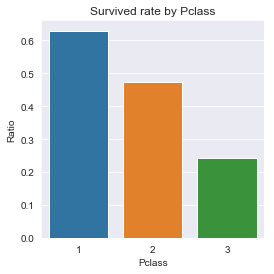


▼ Pclass別の生存数と死亡数 


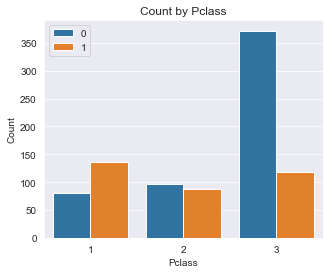


▼ 学習データとテストデータのPclassの乗客数の分布に大きな偏りはない
tag         test     train
Pclass                    
1       0.255981  0.242424
2       0.222488  0.206510
3       0.521531  0.551066

→ 結論：Pclassはダミー変換して利用する


In [263]:
# ------------------------------------------------
# 2-1.Pclassの確認
# ------------------------------------------------
train = all_df.query("tag == 'train'")

# Pclass別の生存率
show_s_rate_barplot(train,"Pclass",4,4)

# Pclass別の生存数カウント
show_state_count_plot(train,"Pclass",5,4)

# Pclassの分布
print("\n▼ 学習データとテストデータのPclassの乗客数の分布に大きな偏りはない")
print(pd.crosstab(all_df['Pclass'],all_df['tag'],normalize='columns'))

print("\n→ 結論：Pclassはダミー変換して利用する")


▼ 学習データとテストデータの敬称を比較
tag           test  train
honorific                
Capt             0      1
Col              2      2
Don              0      1
Dona             1      0
Dr               1      7
Jonkheer         0      1
Lady             0      1
Major            0      2
Master          21     40
Miss            78    182
Mlle             0      2
Mme              0      1
Mr             240    517
Mrs             72    125
Ms               1      1
Rev              2      6
Sir              0      1
the Countess     0      1

→学習データにしか現れない敬称を除外する
['Capt', 'Don', 'Jonkheer', 'Lady', 'Major', 'Mile', 'Mme', 'Sir', 'the Countess']

▼ honorific別の生存率（降順）


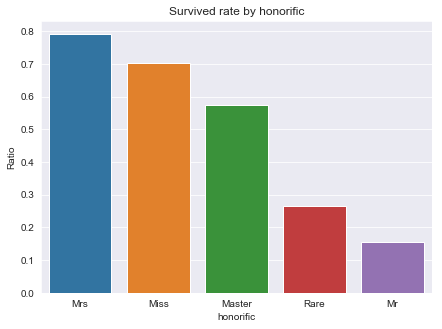


▼ honorific別の生存数と死亡数（降順）


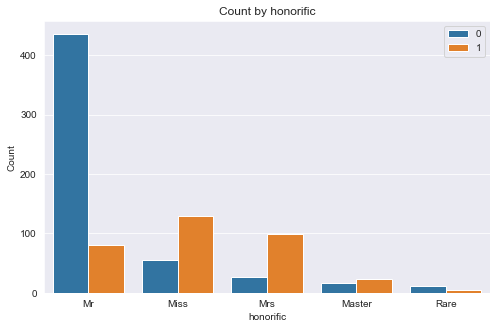


▼ 敬称別の生存率とレコード数
               mean  count
honorific                 
Master     0.575000     40
Miss       0.702703    185
Mr         0.156673    517
Mrs        0.792000    125
Rare       0.266667     15

→ 結論：Nameは除外し、honorificをダミー変換して利用する


In [264]:
# ------------------------------------------------
# 2-2.Nameの確認
# ------------------------------------------------
train = all_df.query("tag == 'train'")

print("\n▼ 学習データとテストデータの敬称を比較")
all_df['honorific'] = all_df['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
print(pd.crosstab(all_df['honorific'],all_df['tag']) )

print("\n→学習データにしか現れない敬称を除外する")
only_train_honorific = ['Capt','Don','Jonkheer','Lady','Major','Mile','Mme','Sir','the Countess']
print(only_train_honorific)

# レコード除外
all_df = all_df[~all_df['honorific'].isin(only_train_honorific) ].reset_index(drop=True)

# 敬称を統合し、ダミー変換する
all_df['honorific'].replace(['Col','Dr', 'Rev'], 'Rare',inplace=True) #少数派の敬称を統合
all_df['honorific'].replace('Mlle', 'Miss',inplace=True) #Missに統合
all_df['honorific'].replace('Ms', 'Miss',inplace=True) #Missに統合

# 再取得
train = all_df.query("tag == 'train'")

# 学習データでのグラフ表示
show_s_rate_barplot(train,"honorific",7,5, True)
show_state_count_plot(train,"honorific",8,5, True)

print("\n▼ 敬称別の生存率とレコード数")
print(train['Survived'].groupby(train['honorific']).agg(['mean','count']))

print("\n→ 結論：Nameは除外し、honorificをダミー変換して利用する")


▼ Fare(運賃)をSurvivedに分けて分布を確認


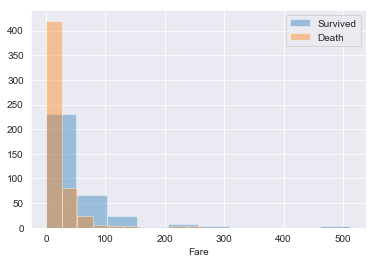

歪度: 4.793762193666624

▼ 分布が歪んでいるためFareを対数変換して再度分布を確認


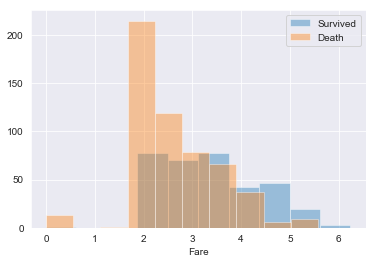


→ 結論：Fareは、標準化して利用する


In [265]:
# ------------------------------------------------
# 2-3.Fare(運賃)の確認
# ------------------------------------------------
print("\n▼ Fare(運賃)をSurvivedに分けて分布を確認")
# Fareの分布
sns.distplot(train[train['Survived']==1]['Fare'],kde=False,rug=False,bins=10,label='Survived')
sns.distplot(train[train['Survived']==0]['Fare'],kde=False,rug=False,bins=10,label='Death')
plt.legend()
plt.show()

#歪度（わいど）
print("歪度:", train['Fare'].skew())

print("\n▼ 分布が歪んでいるためFareを対数変換して再度分布を確認")
sns.distplot(np.log1p(train[train['Survived']==1]['Fare']),kde=False,rug=False,bins=10,label='Survived')
sns.distplot(np.log1p(train[train['Survived']==0]['Fare']),kde=False,rug=False,bins=10,label='Death')
plt.legend()
plt.show()

print("\n→ 結論：Fareは、標準化して利用する")

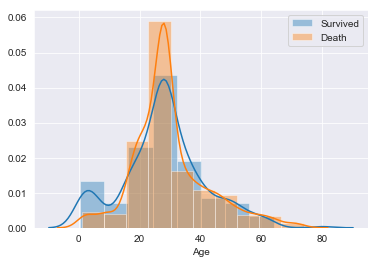


→ 0～20歳までの分布に差が大きく、子供は生き残りやすかったといえる。
  結論：Ageは、標準化して利用する


In [266]:
# ------------------------------------------------
# 2-4.Age(年齢)の確認
# ------------------------------------------------
# Ageの分布
sns.distplot(train_age_omit[train_age_omit['Survived']==1]['Age'],kde=True,rug=False,bins=10,label='Survived') #生存者の分布
sns.distplot(train_age_omit[train_age_omit['Survived']==0]['Age'],kde=True,rug=False,bins=10,label='Death') #死者の分布
plt.legend()
plt.show()

print("\n→ 0～20歳までの分布に差が大きく、子供は生き残りやすかったといえる。")
print("  結論：Ageは、標準化して利用する")


▼ FamilySize別の生存率


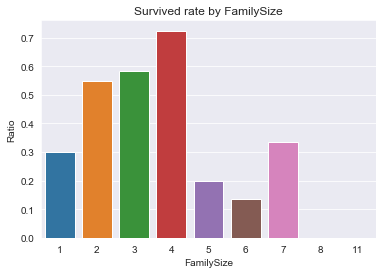


▼ FamilySize別の生存数と死亡数 


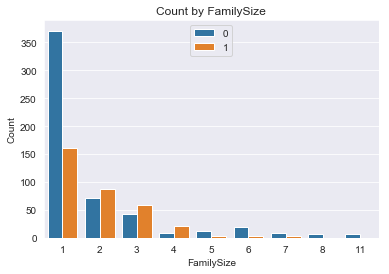


→単身者は死亡率が高く、2人～4人の家族の生存率は高く、5人以上は死亡率が高い。

▼ FamilySize_bin別の生存率


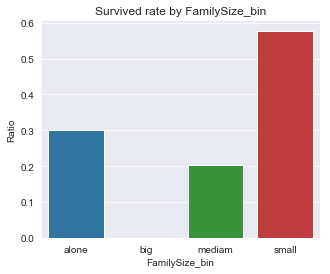


→ 結論：Parch、SibSp、FamilySizeを除外し、FamilySize_binをダミー変換して利用する


In [267]:
# ------------------------------------------------
# 2-5.同乗者数（Parch、SibSp）の確認
# ------------------------------------------------
# 家族数 = Parch + SibSp + 1
all_df['FamilySize'] = all_df['Parch'] + all_df['SibSp'] + 1 #ALLデータ

train = all_df.query("tag == 'train'")

# 家族数ごとの分布を確認
show_s_rate_barplot(train,"FamilySize",6,4)
show_state_count_plot(train,"FamilySize",6,4)

print("\n→単身者は死亡率が高く、2人～4人の家族の生存率は高く、5人以上は死亡率が高い。")

# FamilySizeを離散化
all_df['FamilySize_bin'] = 'big'
all_df.loc[all_df['FamilySize']==1,'FamilySize_bin'] = 'alone'
all_df.loc[(all_df['FamilySize']>=2) & (all_df['FamilySize']<=4),'FamilySize_bin'] = 'small'
all_df.loc[(all_df['FamilySize']>=5) & (all_df['FamilySize']<=7),'FamilySize_bin'] = 'mediam'

# FamilySizeを離散化したときの生存率
train = all_df.query("tag == 'train'")
show_s_rate_barplot(train,"FamilySize_bin",5,4)

print("\n→ 結論：Parch、SibSp、FamilySizeを除外し、FamilySize_binをダミー変換して利用する")

In [270]:
# ------------------------------------------------
# 2-2.ダミー変換
# ------------------------------------------------

# 訓練データを利用
train = all_df.query("tag == 'train'")

# 抽出元の不要な項目を削除
train = train.drop(['PassengerId','Name','Parch','SibSp','FamilySize','tag'], axis=1)

# one-hot-encoding
train = pd.get_dummies(train, columns=['Pclass','Sex','honorific','FamilySize_bin'])

# ------------------------------------------------
# 2-6.データ標準化
# ------------------------------------------------
scaler = StandardScaler()
train['Fare'] = scaler.fit_transform(train.loc[:, ['Fare']])
train['Age'] = scaler.fit_transform(train.loc[:, ['Age']])


print(train.info())


print("\n▼ 先頭5行表示")
print(train.head(5))

#print("\n▼ 基本統計量")
#print(df_d.describe())



<class 'pandas.core.frame.DataFrame'>
Int64Index: 882 entries, 0 to 881
Data columns (total 17 columns):
Survived                 882 non-null int64
Age                      882 non-null float64
Fare                     882 non-null float64
Pclass_1                 882 non-null uint8
Pclass_2                 882 non-null uint8
Pclass_3                 882 non-null uint8
Sex_female               882 non-null uint8
Sex_male                 882 non-null uint8
honorific_Master         882 non-null uint8
honorific_Miss           882 non-null uint8
honorific_Mr             882 non-null uint8
honorific_Mrs            882 non-null uint8
honorific_Rare           882 non-null uint8
FamilySize_bin_alone     882 non-null uint8
FamilySize_bin_big       882 non-null uint8
FamilySize_bin_mediam    882 non-null uint8
FamilySize_bin_small     882 non-null uint8
dtypes: float64(2), int64(1), uint8(14)
memory usage: 39.6 KB
None

▼ 先頭5行表示
   Survived       Age      Fare  Pclass_1  Pclass_2  Pclass_3  Sex

In [271]:
# ****************************************************************************
# ◆ 3.モデル作成
# ****************************************************************************
X = train.drop('Survived', axis=1).values # 説明変数
y = train['Survived'].values              # 目的変数

# ロジスティック回帰モデル生成
clf = SGDClassifier(loss='log',           # ロジスティック回帰を指定
                    penalty='none',       # 正則化を入れる場合はL1､L2→Day2で実施
                    max_iter=10000,       # 繰り返し計算時の強制的終了値、誤差が収束すれば利用しない。
                    fit_intercept=True,   # 切片を有効にするかどうか
                    random_state=1234,    # 乱数のシード
                    tol=1e-3              # 収束する誤差の指定
                   )

# 学習
clf.fit(X, y)

#print('w0 = {:.3f}'.format(clf.intercept_[0]))

# リストへ変換
list_f = list(train.drop('Survived', axis=1).columns)
list_w = np.reshape(clf.coef_[0], -1).tolist()


▼ 回帰係数を表示（絶対値の降順：Top30）
                  feature      weight
0    FamilySize_bin_alone  310.280552
1        honorific_Master  303.712214
2                Pclass_1  290.161839
3            honorific_Mr -272.033790
4   FamilySize_bin_mediam -241.170696
5           honorific_Mrs  215.184483
6                Pclass_3 -192.937420
7    FamilySize_bin_small  156.783918
8      FamilySize_bin_big -147.797071
9              Sex_female  142.283195
10         honorific_Miss  -89.543240
11         honorific_Rare  -79.222963
12              tag_train   78.096703
13               Sex_male  -64.186492
14               Pclass_2  -19.127717
15                    Age  -10.626200
16                   Fare    1.051123


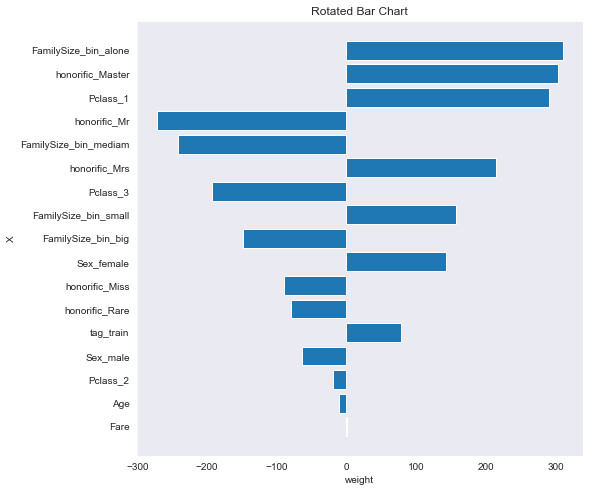

In [209]:
# ------------------------------------------------
# 3-1.重みを表示  
# ------------------------------------------------
list_df = pd.DataFrame(columns=['feature','weight','abs_w'])
for i, feature in enumerate(list_f):
    #print(feature.ljust(30, ' ') + "---->   w{:.0f} = {:.3f}".format(i + 1, list_w[i]))
    list_df = list_df.append( pd.Series([feature,list_w[i],abs(list_w[i])],index=list_df.columns), ignore_index=True)

# 絶対値の降順ソートトップ30
print("\n▼ 回帰係数を表示（絶対値の降順：Top30）")
list_df = list_df.sort_values('abs_w', ascending=False)
list_df.reset_index(drop=True,inplace=True)
list_df = list_df.drop('abs_w', axis=1)
list_head = list_df.head(30)
print(list_head)

# グラフで表示
plt.figure(figsize=(8, 8))
plt.barh(np.arange(len(list_head['feature']))[::-1], list_head['weight'], align='center')
plt.yticks(np.arange(len(list_head['feature']))[::-1], list_head['feature'])
plt.title('Rotated Bar Chart')
plt.xlabel('weight')
plt.ylabel('X')
plt.grid()
plt.show()

In [272]:
# ****************************************************************************
# ◆ 4.モデル評価
# ****************************************************************************

# ラベルを予測
y_est = clf.predict(X)

print('\n▼ モデルの評価結果')

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)

# 成功に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision※精度) = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall※検出率) = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

# 予測値と正解のクロス集計
print('\n▼ 混同行列')
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = 資金調達失敗', '正解 = 資金調達成功'], 
                        columns=['予測 = 資金調達失敗', '予測 = 資金調達成功'])

conf_mat


▼ モデルの評価結果
対数尤度 = -6.109
正答率 = 82.313%
適合率（Precision※精度) = 82.255%
再現率（Recall※検出率) = 91.009%
F1値（F1-score） = 86.411%

▼ 混同行列


,予測 = 資金調達失敗,予測 = 資金調達成功
正解 = 資金調達失敗,496,49
正解 = 資金調達成功,107,230
